# 04_3: TF-IDF Vectorization Modeling

---

## Imports

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocessor as p
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_colwidth = 400

---

## Load Data

In [293]:
# Hashtag labeled data
tweets_h = pd.read_csv('../data/hashlabeled_tweets_train.csv')
tweets_h.shape

(25466, 5)

In [294]:
tweets_h.isnull().sum()

datetime       0
text           0
p_text         0
hashtag        0
get_vaccine    0
dtype: int64

In [299]:
tweets_h['get_vaccine'].value_counts(normalize=True)

0    0.509424
1    0.490576
Name: get_vaccine, dtype: float64

In [290]:
# Snorkel labeled data
tweets_s = pd.read_csv('../data/snorklabeled_tweets_train.csv')
tweets_s.shape

(60515, 3)

In [292]:
tweets_s.isnull().sum()

datetime    0
text        0
label       0
dtype: int64

In [297]:
tweets_s['label'].value_counts(normalize=True)

1    0.863455
0    0.136545
Name: label, dtype: float64

Hashtag-labeled data is balanced, given the method of collection. Snorkel-labeled data is highly imbalanced and will require some adjustment before modeling. 

## Hashtag-labeled Data Modeling

**Train-Test Split**

In [329]:
X = tweets_h['p_text'] # will use processed text column
y = tweets_h['get_vaccine']

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y)

**Baseline Accuracies**

In [46]:
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

0    0.509424
1    0.490576
Name: get_vaccine, dtype: float64
0    0.509425
1    0.490575
Name: get_vaccine, dtype: float64
0    0.509423
1    0.490577
Name: get_vaccine, dtype: float64


Baseline accuracy is about 0.5; the model should at the least beat accuracy of 0.5.

**TF-IDF Vectorizer**

In [47]:
# following lemmatizer object will be used as the tokenizer when creating Tfidf vectors, so that 
# the tokens created will be lemmatized. 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [304]:
# Update the stopwords according the the warning recieved when tokenizing. 
# This is resulted due to words being tokenized before stopwords get removed. 
stopwords = stopwords.words('english')
new_stop_words = ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
stopwords.extend(new_stop_words)

In [330]:
tvec = TfidfVectorizer(lowercase=True, 
                        preprocessor=None, 
                        tokenizer=LemmaTokenizer(), 
                        stop_words=stopwords, 
                        analyzer='word')

X_train_tvec = tvec.fit_transform(X_train)
X_val_tvec = tvec.transform(X_val)

### Model Selection

In [50]:
# Following are the classifiers that will be tested for the text binary classification
classifiers = {
    'logreg' : LogisticRegression(random_state=42, max_iter=1000),
    'svc' : SVC(random_state=42),
    'random_forests' : RandomForestClassifier(random_state=42),
    'multinomialNB' : MultinomialNB(),
    'knearestneighbors' : KNeighborsClassifier(),
    'adaboost' : AdaBoostClassifier(random_state=42, base_estimator=DecisionTreeClassifier()),
    'xgboost' : XGBClassifier()
}

In [51]:
# Define a function that fits a model and compiles the metrics
def run_models(model, 
               X_train, y_train, X_test, y_test,
               verbose=True):

    results = {} # instantiate results dictionary to store different metric scores
    
    model.fit(X_train, y_train) # fit the model

    y_pred_train = model.predict(X_train) # make train and test predictions 
    y_pred_test = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    
    results['train_accuracy'] = accuracy_score(y_train, y_pred_train)
    results['test_accuracy'] = accuracy_score(y_test, y_pred_test)
    results['variance'] = results['train_accuracy'] - results['test_accuracy']
    results['test_precision'] = precision_score(y_test, y_pred_test, pos_label=1, zero_division=0)
    results['test_recall'] = recall_score(y_test, y_pred_test)
    results['test_specificity'] = tn / (tn + fp)
    results['test_f1'] = f1_score(y_test, y_pred_test, pos_label=1, zero_division=0)
    
    return results

In [52]:
# Define a function that accepts a dictionary of classifiers and applies the run_model function defined above
# Then, the function compiles all the model results into a dataframe
def model_results(models, X_train, y_train, X_test, y_test, verbose=False):
    
    results = {}
    
    for name, model in models.items():
        if verbose:
            print('\nRunning {} - {}'.format(name, model))
        
        results[name] = run_models(model, X_train, y_train, X_test, y_test, verbose=False)

    return pd.DataFrame.from_dict(results, orient='index')


In [53]:
# baseline model results for hash-labeled data
model_results(classifiers,
              X_train_tvec,
              y_train,
              X_val_tvec,
              y_val
             )

,train_accuracy,test_accuracy,variance,test_precision,test_recall,test_specificity,test_f1
logreg,0.848861,0.779348,0.069513,0.796720,0.738695,0.818497,0.766611
svc,0.959798,0.789164,0.170634,0.814848,0.737895,0.838536,0.774465
random_forests,0.989299,0.762073,0.227226,0.762332,0.748299,0.775337,0.755250
multinomialNB,0.844738,0.773852,0.070886,0.788190,0.737095,0.809249,0.761787
knearestneighbors,0.733752,0.579898,0.153854,0.552501,0.755902,0.410405,0.638391
adaboost,0.989299,0.700824,0.288475,0.696970,0.690276,0.710983,0.693607
xgboost,0.823925,0.747939,0.075986,0.779567,0.677871,0.815414,0.725171


Overall, the models generally have high variance. SVC is the best performer in terms of the test accuracy and logreg is somewhat comparable with lower variance. The two models have comparable recall and specificity scores. Taking training time into account, I will choose to tune logistic regression model with regularization. 


The error metric to optimize for would depend on the application of the labels, but as a general application, I will be looking at the accuracy and f1 score. 

### RadomizedGridSearch Pipeline

In [307]:
# logistic regression
logr_pipe = Pipeline([
    ('logr_tvec', TfidfVectorizer(lowercase=True, 
                                  preprocessor=None,
                                  tokenizer=LemmaTokenizer(),
                                  stop_words=stopwords,
                                  analyzer='word')), 
    ('logr', LogisticRegression(penalty='elasticnet',
                                solver='saga'
                               ))
])

In [318]:
logr_pipe_params = {
    'logr_tvec__max_features' : [None, 2000, 4000],
    'logr_tvec__ngram_range' : [(1,1),(1,2)],
    'logr__C': [0.001, 0.01, 0.1, 0.5],
    'logr__l1_ratio': [0.01, 0.1, 0.5, 0.9]
}

In [319]:
logr_rs = RandomizedSearchCV(logr_pipe,
                             param_distributions = logr_pipe_params, 
                             n_iter=10,
                             cv = 3,
                             random_state=42)

In [324]:
logr_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('logr_tvec',
                                              TfidfVectorizer(stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
              

In [325]:
logr_rs.best_params_

{'logr_tvec__ngram_range': (1, 2),
 'logr_tvec__max_features': None,
 'logr__l1_ratio': 0.01,
 'logr__C': 0.5}

In [327]:
logr_rs.best_score_

0.7718437300458381

In [331]:
logr_rs.score(X_val, y_val)

0.7771888496270122

The score isn't particularly better than the baseline model, but incorporating the regularization seems to have reduced the variance of the model. 

### Test Model

In [332]:
# load test set
test_h = pd.read_csv("../data/hashlabeled_tweets_test.csv")

In [333]:
X_test_h = test_h['p_text']
y_test_h = test_h['get_vaccine']

In [334]:
# pipeline
logr_pipe_f = Pipeline([
    ('logr_tvec', TfidfVectorizer(lowercase=True, 
                                  preprocessor=None,
                                  tokenizer=LemmaTokenizer(),
                                  stop_words=stopwords,
                                  analyzer='word',
                                  ngram_range=(1, 2),
                                 )), 
    ('logr', LogisticRegression(penalty='elasticnet',
                                solver='saga',
                                l1_ratio=0.01,
                                C=0.5
                               ))
])

In [338]:
logr_rs.score(X_test_h, y_test_h)

0.7708136977693999

In [337]:
preds_h = logr_rs.predict(X_test_h)

In [342]:
def test_result(y_true, y_pred):
    results = {}
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    results['recall'] = recall_score(y_true, y_pred)
    results['specificity'] = tn / (tn + fp)
    results['f1'] = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    
    return results

In [343]:
test_result(y_test_h, preds_h)

{'accuracy': 0.7708136977693999,
 'precision': 0.7922077922077922,
 'recall': 0.7224711907810499,
 'specificity': 0.8173966687230105,
 'f1': 0.7557341369496066}

final accuracy score of hash labeled dataset prediction model is 0.77.

___

## Snorkel-Labeled Data Modeling

In [350]:
# processing function
def text_process(df, text):
    # Removing hashtags, URLs, mentions, reserved words, emojis, smileys
    df['p_text'] = df[text].apply(lambda x: p.clean(x))
    
    # Remove digits
    df['p_text'] = df['p_text'].str.replace('\d+', '', regex=True)
    
    # remove punctuations
    df['p_text'] = df['p_text'].str.replace('&amp', '')
    df['p_text'] = df['p_text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    
    # lower case
    df['p_text'] = df['p_text'].str.lower()
    
    # remove stopwords first
    stop_words = stopwords
    df['p_text'] = df['p_text'].apply(lambda x: " ".join([item for item in x.split(' ') if item not in stop_words]))
    
    # tokenize and lemmatize
    lem = WordNetLemmatizer()
    tok = TweetTokenizer()
    
    for i, txt in enumerate(df['p_text']):
        lem_words = [lem.lemmatize(word) for word in tok.tokenize(txt)]
        df.at[i, 'p_text'] = ' '.join(lem_words)

In [84]:
# process the text data, as it wasn't done so previously
text_process(tweets_s, 'text')

**Train/Test Split**

In [191]:
X = tweets_s[['p_text']]
y = tweets_s['label']

In [192]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [193]:
X_val = X_val['p_text']

In [196]:
y_train.value_counts()

1    41802
0     6610
Name: label, dtype: int64

**Balancing Dataset**

I will have to deal with the imbalance of data. In this model, I will chose to do ensemble of undersampled datasets. This means that I will divide the training data with majority label into subsets that balance with the minority label. The final prediction of the test set will be the label that majority of the subset trained models predicted. 

In [197]:
# check how many training subsets need to be created
48412/6610

7.324054462934947

In [198]:
# Divide the training data with class 1 into the number of subsets calculated above
48412/7

6916.0

Each subset will contain 6916 rows with label 1 and 6610 rows with label 0. For each subset training, same set of rows with label 0 will be used. 

In [ ]:
# Range of indexs for each subset; since the dataset is already shuffled during train-test split, 
# it is not necessary to take random samples.

# 0-6916, 6916-13832, 13832-20748, 20748-27664, 27664-34580, 34580-41496, 41496-48412

In [194]:
# create dataframe to split on just with train data
df = X_train.copy()
df['label'] = y_train

In [195]:
df.shape

(48412, 2)

In [207]:
df.head()

,p_text,label
8755,de blasio insists nyc vaccine equity issue even time new york post mayor bill de blasio monday insisted massive gap covid vaccination betwee add highlight,1
543,youve mingles dont need worry abt whats covid vaccine,1
25489,sinovac vaccine help thailand control covid pandemic thailand news asean,1
20125,vaccine dos give protection death covid delta variant centre,1
47337,prosecutor said motivated conspiracy theory surrounding covid vaccine,1


In [208]:
# divide the train df by its class
df_class0 = df[df.label==0] # minority class
df_class1 = df[df.label==1] # majority class

In [209]:
# This is a function that will put together subset of majorty class of specified range with a minority class
# Then, it splits the data into X and y train again
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train['p_text']
    y_train = df_train['label']
    return X_train, y_train    

In [359]:
# Create subsets
X_train1, y_train1 = get_train_batch(df_class1, df_class0, 0, 6916)
X_train2, y_train2 = get_train_batch(df_class1, df_class0, 6916, 18342)
X_train3, y_train3 = get_train_batch(df_class1, df_class0, 13832, 20748)
X_train4, y_train4 = get_train_batch(df_class1, df_class0, 20748, 27664)
X_train5, y_train5 = get_train_batch(df_class1, df_class0, 27664, 34580)
X_train6, y_train6 = get_train_batch(df_class1, df_class0, 34580, 41496)
X_train7, y_train7 = get_train_batch(df_class1, df_class0, 41496, 48412)

**TF-IDF Vectorizer**

In [226]:
# instanitate tvec for the first set of data
tvec1 = TfidfVectorizer(lowercase=True, 
                        preprocessor=None, 
                        tokenizer=LemmaTokenizer(), 
                        stop_words=stopwords, 
                        analyzer='word')

X_train1 = tvec1.fit_transform(X_train1)
X_val1 = tvec1.transform(X_val)

In [227]:
# Quick run through of all of the models
model_results(classifiers,
              X_train1,
              y_train1,
              X_val1,
              y_val
             )

,train_accuracy,test_accuracy,variance,test_precision,test_recall,test_specificity,test_f1
logreg,0.920154,0.869536,0.050617,0.975555,0.870718,0.862069,0.920160
svc,0.991276,0.876229,0.115047,0.976576,0.877703,0.866909,0.924504
random_forests,0.999926,0.832851,0.167075,0.979843,0.823349,0.892922,0.894805
multinomialNB,0.868180,0.706602,0.161578,0.976384,0.676555,0.896552,0.799276
knearestneighbors,0.718542,0.834256,-0.115714,0.896879,0.913014,0.336358,0.904875
adaboost,0.999926,0.859869,0.140057,0.963469,0.870718,0.791289,0.914748
xgboost,0.925699,0.901429,0.024269,0.974377,0.909761,0.848760,0.940961


With the baseline run of the first subset, we can see that xgboost is the strongest performer with a low variance. Therefore, the rest of the subsets will be trained with XGBoost Classifier. 

In [100]:
# specifically with XGBoost for other subsets
def run_xgb(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    
    results = {} 
    
    results['train_accuracy'] = accuracy_score(y_train, y_pred_train)
    results['test_accuracy'] = accuracy_score(y_test, y_pred_test)
    results['variance'] = results['train_accuracy'] - results['test_accuracy']
    results['test_precision'] = precision_score(y_test, y_pred_test, pos_label=1, zero_division=0)
    results['test_recall'] = recall_score(y_test, y_pred_test)
    results['test_specificity'] = tn / (tn + fp)
    results['test_f1'] = f1_score(y_test, y_pred_test, pos_label=1, zero_division=0)
    
    model_dict = {'results': results, "preds_train": y_pred_train, "preds_test": y_pred_test}
    
    return model_dict # The function will return a dictionary that stores the metric result and the predictions

In [229]:
# re-analyze subset 1
subset1 = run_xgb(X_train1,
                  y_train1,
                  X_val1,
                  y_val)

In [230]:
# Instantiate tfidf and run the function for all of the subsets. 
tvec2 = TfidfVectorizer(lowercase=True, 
                        preprocessor=None, 
                        tokenizer=LemmaTokenizer(), 
                        stop_words=stopwords, 
                        analyzer='word')

X_train2 = tvec2.fit_transform(X_train2)
X_val2 = tvec2.transform(X_val)

subset2 = run_xgb(X_train2,
                  y_train2,
                  X_val2,
                  y_val)

In [231]:
tvec3 = TfidfVectorizer(lowercase=True, 
                        preprocessor=None, 
                        tokenizer=LemmaTokenizer(), 
                        stop_words=stopwords, 
                        analyzer='word')

X_train3 = tvec3.fit_transform(X_train3)
X_val3 = tvec3.transform(X_val)

subset3 = run_xgb(X_train3,
                  y_train3,
                  X_val3,
                  y_val)

In [232]:
tvec4 = TfidfVectorizer(lowercase=True, 
                        preprocessor=None, 
                        tokenizer=LemmaTokenizer(), 
                        stop_words=stopwords, 
                        analyzer='word')

X_train4 = tvec4.fit_transform(X_train4)
X_val4 = tvec4.transform(X_val)

subset4 = run_xgb(X_train4,
                  y_train4,
                  X_val4,
                  y_val)

In [233]:
tvec5 = TfidfVectorizer(lowercase=True, 
                        preprocessor=None, 
                        tokenizer=LemmaTokenizer(), 
                        stop_words=stopwords, 
                        analyzer='word')

X_train5 = tvec5.fit_transform(X_train5)
X_val5 = tvec5.transform(X_val)

subset5 = run_xgb(X_train5,
                  y_train5,
                  X_val5,
                  y_val)

In [236]:
tvec6 = TfidfVectorizer(lowercase=True, 
                        preprocessor=None, 
                        tokenizer=LemmaTokenizer(), 
                        stop_words=stopwords, 
                        analyzer='word')

X_train6 = tvec6.fit_transform(X_train6)
X_val6 = tvec6.transform(X_val)

subset6 = run_xgb(X_train6,
                  y_train6,
                  X_val6,
                  y_val)

In [237]:
tvec7 = TfidfVectorizer(lowercase=True, 
                        preprocessor=None, 
                        tokenizer=LemmaTokenizer(), 
                        stop_words=stopwords, 
                        analyzer='word')

X_train7 = tvec7.fit_transform(X_train7)
X_val7 = tvec7.transform(X_val)

subset7 = run_xgb(X_train7,
                  y_train7,
                  X_val7,
                  y_val)

In [238]:
# metric compiled into dataframe
subsets = [subset1['results'], 
           subset2['results'],
           subset3['results'],
           subset4['results'],
           subset5['results'],
           subset6['results'],
           subset7['results']]

In [239]:
xgb_results = pd.DataFrame.from_dict(subsets)

In [240]:
xgb_results

,train_accuracy,test_accuracy,variance,test_precision,test_recall,test_specificity,test_f1
0,0.925699,0.901429,0.024269,0.974377,0.909761,0.848760,0.940961
1,0.926425,0.924316,0.002109,0.966256,0.945359,0.791289,0.955693
2,0.922372,0.906965,0.015407,0.974552,0.916172,0.848760,0.944461
3,0.923776,0.905313,0.018464,0.974888,0.913876,0.851180,0.943396
4,0.923037,0.901595,0.021442,0.975454,0.908900,0.855414,0.941002
5,0.922815,0.899199,0.023617,0.973722,0.907751,0.845130,0.939580
6,0.972383,0.243328,0.729055,0.997689,0.123923,0.998185,0.220463


The last set is a very odd outlier; the accuracy is far lower than the other 6, which are pretty consistent. The low accuracy would indicate low reliability of the model and it will be excluded from participating in the majority vote for labeling. 

The problem now is that the vote can split evenly with even number of models. Labeling the evenly split votes with -1, I found that the number of evenly split predictions was about 100, which is not significant fraction of the dataset. In such case, I will randomly assign 1 or 0.

In [286]:
y_pred_final = subset1['preds_test'].copy()

for i in range(len(subset1['preds_test'])):
    n_ones = sum([subset1['preds_test'][i],
                  subset2['preds_test'][i],
                  subset3['preds_test'][i],
                  subset4['preds_test'][i],
                  subset5['preds_test'][i],
                  subset6['preds_test'][i]])             
    
    if n_ones > 3:
        y_pred_final[i] = 1
    elif n_ones == 3:
        y_pred_final[i] = np.random.choice(2, 1) # will choose randomly if ties
    elif n_ones < 3:
        y_pred_final[i] = 0

In [289]:
cl_rep = classification_report(y_val, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.63      0.85      0.72      1653
           1       0.98      0.92      0.95     10450

    accuracy                           0.91     12103
   macro avg       0.80      0.89      0.83     12103
weighted avg       0.93      0.91      0.92     12103



### Test Model

In [348]:
test_s = pd.read_csv("../data/snorklabeled_tweets_test.csv")

In [351]:
text_process(test_s, 'text')

In [354]:
X_test_s = test_s['p_text']
y_test_s = test_s['label']

In [345]:
xgb_pipe = Pipeline([
    ('xgb_tvec', TfidfVectorizer(lowercase=True, 
                                  preprocessor=None,
                                  tokenizer=LemmaTokenizer(),
                                  stop_words=stopwords,
                                  analyzer='word'
                                 )), 
    ('xgb', XGBClassifier())
])

In [356]:
def xgb_preds(X_train, y_train, X_test):
    xgb_pipe.fit(X_train, y_train)
    preds = xgb_pipe.predict(X_test)
    
    return preds

In [360]:
pred1 = xgb_preds(X_train1, y_train1, X_test_s)
pred2 = xgb_preds(X_train2, y_train2, X_test_s)
pred3 = xgb_preds(X_train3, y_train3, X_test_s)
pred4 = xgb_preds(X_train4, y_train4, X_test_s)
pred5 = xgb_preds(X_train5, y_train5, X_test_s)
pred6 = xgb_preds(X_train6, y_train6, X_test_s)

In [368]:
test_pred = pred1.copy()

for i in range(len(pred1)):
    n_ones = sum([pred1[i],
                  pred2[i],
                  pred3[i],
                  pred4[i],
                  pred5[i],
                  pred6[i]])             
    
    if n_ones > 3:
        test_pred[i] = 1
    elif n_ones == 3:
        test_pred[i] = np.random.choice(2, 1) # will choose randomly if ties
    elif n_ones < 3:
        test_pred[i] = 0

There were 250 tied vote, which is small portion of the dataframe. As I did with the validation set, I randomly assigned 0 or 1. 

In [369]:
np.unique(test_pred, return_counts=True)

(array([0, 1]), array([ 2808, 12321]))

In [371]:
test_report = classification_report(y_test_s, test_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.61      0.84      0.71      2042
           1       0.97      0.92      0.94     13087

    accuracy                           0.91     15129
   macro avg       0.79      0.88      0.83     15129
weighted avg       0.93      0.91      0.91     15129



Final accuracy of the Snorkel-Labeled model is 0.91.

---

## Insights

In [380]:
# baseline scores
base_h = np.full_like(preds_h, 1)
base_s = np.full_like(test_pred, 1)

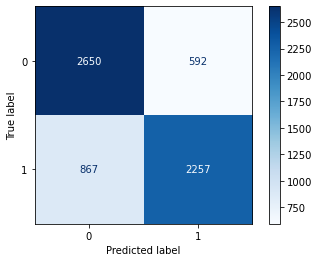

In [378]:
# Hashtag labeled data
ConfusionMatrixDisplay.from_predictions(y_test_h, preds_h, cmap='Blues');

In [389]:
print(classification_report(y_test_h, preds_h))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      3242
           1       0.79      0.72      0.76      3124

    accuracy                           0.77      6366
   macro avg       0.77      0.77      0.77      6366
weighted avg       0.77      0.77      0.77      6366



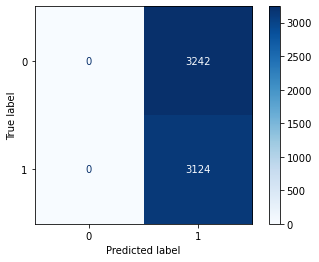

In [381]:
# baseline
ConfusionMatrixDisplay.from_predictions(y_test_h, base_h, cmap='Blues');

In [391]:
print(classification_report(y_test_h, base_h, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3242
           1       0.49      1.00      0.66      3124

    accuracy                           0.49      6366
   macro avg       0.25      0.50      0.33      6366
weighted avg       0.24      0.49      0.32      6366



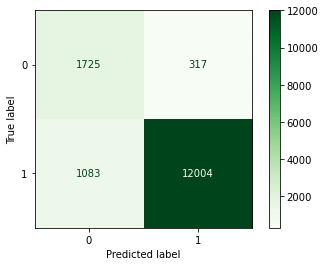

In [379]:
# Snorkel labeled data
ConfusionMatrixDisplay.from_predictions(y_test_s, test_pred, cmap='Greens');

In [385]:
print(test_report)

              precision    recall  f1-score   support

           0       0.61      0.84      0.71      2042
           1       0.97      0.92      0.94     13087

    accuracy                           0.91     15129
   macro avg       0.79      0.88      0.83     15129
weighted avg       0.93      0.91      0.91     15129



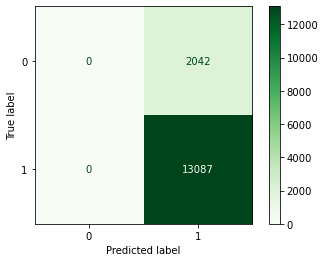

In [383]:
# baseline
ConfusionMatrixDisplay.from_predictions(y_test_s, base_s, cmap='Greens');

In [388]:
print(classification_report(y_test_s, base_s, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2042
           1       0.87      1.00      0.93     13087

    accuracy                           0.87     15129
   macro avg       0.43      0.50      0.46     15129
weighted avg       0.75      0.87      0.80     15129



With both the hashtag-labeled and Snorkel-labeled dataset, the best performing model does beat the baseline accuracy. 

TFIDF vectorizing with regularized logistic regression on Hashtag labeled data scored 0.77 accuracy, where baseline score was 0.5. Recall for the 0 class label (anti_vax) was higher than that of 1 class, meaning that the model had higher coverage of 0 class prediction. However, the precision was slightly lower, likely indicating that the model tends to overestimate the anti_vax texts. 

Predicting Snorkel labeled data (TFIDF vectors with XGBoost Classification) scored 0.91 in accuracy. Considering the baseline accuracy of 0.87, the model beat the baseline by about 0.04. Referring to the confusion matrix, the model over-predicted on the class 0 anti_vax, lowering its precision. There seems to be some trade off between 0 class precision and its recall of score 0.84. 

Aside from the model performance, it is slightly questionable how the model decently performed on the snorkel labeled dataset. This could be some investigation point in the next step, to look into whether the model is picking up the features from data with wrong label or if the Snorkel development set accuracy simply underestimated the accuracy of Snorkel labeling function.  